# Black Hole (Spinning) Initial Data

In [1]:
"""Code to construct puncture initial data for single spinning black hole."""
import sys
from numpy import zeros, size, sqrt, linspace
import scipy.linalg as la

In [2]:
class EllipticSolver:
    """Class Elliptic solves Poisson-type elliptic equations of the form:
          D^2 sol + fct sol = rhs
    where
        - D^2 is the flat Laplace operator
        - fct and rhs are user-supplied functions of the coordinates x, y, z
        - and sol is the solution.

    To use this class:
        - initialize the class, providing Cartesian coordinates x, y, and z
        - call setup_matrix(fct) to set up the operator
        - call setup_rhs(rhs) to set up the right-hand side
        - then a call to solve() returns the solution sol
    """

    def __init__(self, x, y, z):
        """Constructor - provide Cartesian coordinates, all of length n_grid,
        as arguments.
        """

        print(" Setting up Poisson solver...")
        self.n_grid = size(x)
        self.delta = x[1] - x[0]

        # set up storage for matrix, solution, r.h.s.
        # Note: "sol" and "rhs" will store functions in 3d format, while
        # "sol_1d" and "rhs_1d" will store functions in 1d format using superindex I
        
        nnn = self.n_grid ** 3
        self.rhs_1d = zeros(nnn)
        self.A = zeros((nnn, nnn)) # N^3 * N^3 dimensional matrix 
        self.sol = zeros((self.n_grid, self.n_grid, self.n_grid))
        self.rad = zeros((self.n_grid, self.n_grid, self.n_grid))  # radius = r, needed to set Robin BC.

        # compute radius
        for i in range(0, self.n_grid):
            for j in range(0, self.n_grid):
                for k in range(0, self.n_grid):
                    rad2 = x[i] ** 2 + y[j] ** 2 + z[k] ** 2
                    self.rad[i, j, k] = sqrt(rad2)


    def setup_matrix(self, fct):
        """Set up matrix A."""

        n_grid = self.n_grid   # for simplicity

        # Use Robin boundary conditions (B.30) to set up boundaries
        i = 0  # lower x-boundary
        for j in range(0, n_grid):
            for k in range(0, n_grid):
                index = self.super_index(i, j, k)  # super index function is defined below. (index = I)
                self.A[index, index] = self.rad[i, j, k]
                self.A[index, index + 1] = -self.rad[i + 1, j, k]

        i = n_grid - 1  # upper x-boundary
        for j in range(0, n_grid):
            for k in range(0, n_grid):
                index = self.super_index(i, j, k)
                self.A[index, index] = self.rad[i, j, k]
                self.A[index, index - 1] = -self.rad[i - 1, j, k]

        j = 0  # lower y-boundary
        for i in range(1, n_grid - 1): 
            for k in range(0, n_grid):
                index = self.super_index(i, j, k)
                self.A[index, index] = self.rad[i, j, k]
                self.A[index, index + n_grid] = -self.rad[i, j + 1, k]

        j = n_grid - 1  # upper y-boundary
        for i in range(1, n_grid - 1):
            for k in range(0, n_grid):
                index = self.super_index(i, j, k)
                self.A[index, index] = self.rad[i, j, k]
                self.A[index, index - n_grid] = -self.rad[i, j - 1, k]

        k = 0  # lower z-boundary
        for i in range(1, n_grid - 1):
            for j in range(1, n_grid - 1):
                index = self.super_index(i, j, k)
                self.A[index, index] = self.rad[i, j, k]
                self.A[index, index + n_grid * n_grid] = -self.rad[i, j, k + 1]

        k = n_grid - 1  # upper z-boundary
        for i in range(1, n_grid - 1):
            for j in range(1, n_grid - 1):
                index = self.super_index(i, j, k)
                self.A[index, index] = self.rad[i, j, k]
                self.A[index, index - n_grid * n_grid] = -self.rad[i, j, k - 1]

        # use (B.29) to fill matrix in interior
        for i in range(1, n_grid - 1):
            for j in range(1, n_grid - 1):
                for k in range(1, n_grid - 1):
                    index = self.super_index(i, j, k)

                    # diagonal element
                    self.A[index, index] = -6. + self.delta ** 2 * fct[i, j, k]

                    # off-diagonal elements
                    self.A[index, index - 1] = 1.0
                    self.A[index, index + 1] = 1.0
                    self.A[index, index - n_grid] = 1.0
                    self.A[index, index + n_grid] = 1.0
                    self.A[index, index - n_grid * n_grid] = 1.0
                    self.A[index, index + n_grid * n_grid] = 1.0


    def setup_rhs(self, rhs):
        """Setup right-hand side of matrix equation"""

        n_grid = self.n_grid
        for i in range(1, n_grid - 1):
            for j in range(1, n_grid - 1):
                for k in range(1, n_grid - 1):
                    index = self.super_index(i, j, k)
                    self.rhs_1d[index] = self.delta ** 2 * rhs[i, j, k]


    def solve(self):
        """Interface to scipy.linalg matrix solver,
        returns sol (in 3d format)."""

        # solve matrix using scipy.linalg interface...
        sol_1d = la.solve(self.A, self.rhs_1d)

        # ... then translate from superindex to 3d
        for i in range(0, self.n_grid):
            for j in range(0, self.n_grid):
                for k in range(0, self.n_grid):
                    index = self.super_index(i, j, k)
                    self.sol[i, j, k] = sol_1d[index]

        return self.sol


    def super_index(self, i, j, k):
        """Compute super index, see (B.28)."""
        return i + self.n_grid * (j + self.n_grid * k)

In [3]:
class Puncture:
    """Class that handles construction of puncture data.

    To use this class,
       - initialize class with physical parameters as arguments
       - then call construct_solution.
    """

    def __init__(self, bh_loc, ang_mom, n_grid, x_out):
        """Arguments to constructor specify physical parameters:
        - location of puncture (bh_loc)
        - angular momentum (ang_mom)
        - size of grid (n_grid)
        - outer boundary (x_out).
        """
        self.bh_loc = bh_loc
        self.ang_mom = ang_mom
        
        # echo out parameters
        print(" Constructing class Puncture for single black hole")
        print("    at bh_loc = (", bh_loc[0], ",", bh_loc[1], ",",
                  bh_loc[2], ")") 
        print("    with ang. momentum j = (", ang_mom[0], ",",
                  ang_mom[1], ",", ang_mom[2], ")") 
        print(" Using", n_grid,"\b^3 gridpoints with outer boundary at", x_out)
        
        # set up grid
        self.n_grid = n_grid
        self.x_out = x_out
        self.delta = 2.0 * x_out / n_grid  # -x_out to +x_out

        # set up coordinates: use cell-centered grid covering (-x_out, x_out)
        # in each dimension; see (B.14)
        half_delta = self.delta / 2.0
        self.x = linspace(half_delta - x_out, x_out -
                          half_delta, n_grid)
        self.y = linspace(half_delta - x_out, x_out -
                          half_delta, n_grid)
        self.z = linspace(half_delta - x_out, x_out -
                          half_delta, n_grid)

        # allocate elliptic solver
        self.solver = EllipticSolver(self.x, self.y, self.z)

        # allocate memory for functions u, alpha, beta, and residual
        self.alpha = zeros((n_grid, n_grid, n_grid))
        self.beta = zeros((n_grid, n_grid, n_grid))
        self.u = zeros((n_grid, n_grid, n_grid))
        self.res = zeros((n_grid, n_grid, n_grid))


    def construct_solution(self, tol, it_max):
        """Construct solution iteratively, provide tolerance and maximum number of iterations as arguments."""

        self.setup_alpha_beta()
        residual_norm = self.residual()
        print(" Initial Residual = ", residual_norm)
        print(" Using up to", it_max, "iteration steps to reach tolerance of",
                  tol)

        # now iterate...
        it_step = 0
        while residual_norm > tol and it_step < it_max:
            it_step += 1
            self.update_u()
            residual_norm = self.residual()
            print(" Residual after", it_step, "iterations :", residual_norm)
        if (residual_norm < tol):
            print(" Done!")
        else:
            print(" Giving up...")

            
    def update_u(self):
        """Function that updates u using Poisson solver;
        takes one iteration step.
        """

        # set up linear term and right-hand side for SolvePoisson...
        n_grid = self.n_grid
        fct = zeros((n_grid, n_grid, n_grid))
        rhs = zeros((n_grid, n_grid, n_grid))

        for i in range(1, n_grid - 1):
            for j in range(1, n_grid - 1):
                for k in range(1, n_grid - 1):
                    # compute h' from (B.39)
                    temp = self.alpha[i, j, k] * (1.0 + self.u[i, j, k]) + 1.0  # page 160
                    fct[i, j, k] = (-7.0 * self.beta[i, j, k] *
                                    self.alpha[i, j, k] / temp ** 8)
                    rhs[i, j, k] = -self.res[i, j, k]

        # now update Poisson solver
        self.solver.setup_matrix(fct)

        # set up right-hand side
        self.solver.setup_rhs(rhs)

        # solve to find delta_u, see (B.36)
        delta_u = self.solver.solve()

        # update u
        self.u += delta_u


    def residual(self):
        """Evaluate residual, see (B.35)."""
        
        residual_norm = 0.0
        for i in range(1, self.n_grid - 1):
            for j in range(1, self.n_grid - 1):
                for k in range(1, self.n_grid - 1):

                    # compute left-hand side: Laplace operator
                    ddx = (self.u[i + 1, j, k] - 2.0 * self.u[i, j, k] +
                           self.u[i - 1, j, k])
                    ddy = (self.u[i, j + 1, k] - 2.0 * self.u[i, j, k] +
                           self.u[i, j - 1, k])
                    ddz = (self.u[i, j, k + 1] - 2.0 * self.u[i, j, k] +
                           self.u[i, j, k - 1])
                    lhs = (ddx + ddy + ddz) / self.delta ** 2

                    # compute right-hand side,
                    # recall h = - beta/(alpha + alpha u + 1)^7
                    temp = self.alpha[i, j, k] * (1.0 + self.u[i, j, k]) + 1.0
                    rhs = -self.beta[i, j, k] / temp ** 7

                    # then compute difference to get residual, see (B.35)
                    self.res[i, j, k] = lhs - rhs
                    residual_norm += self.res[i, j, k] ** 2

        residual_norm = sqrt(residual_norm) * self.delta ** 3
        return residual_norm
    
    """Multiplying by self.delta ** 3 ensures that the residual norm is properly scaled with respect to 
    the volume or size of the grid cells, providing a meaningful measure of the overall 
    residual in the simulation domain."""


    def setup_alpha_beta(self):
        """Set up functions alpha and beta."""

        n_grid = self.n_grid
        j_x = self.ang_mom[0]
        j_y = self.ang_mom[1]
        j_z = self.ang_mom[2]

        for i in range(0, n_grid):
            for j in range(0, n_grid):
                for k in range(0, n_grid):
                    s_x = self.x[i] - self.bh_loc[0]
                    s_y = self.y[j] - self.bh_loc[1]
                    s_z = self.z[k] - self.bh_loc[2]
                    s = sqrt(s_x ** 2 + s_y ** 2 + s_z ** 2)
                    s_bh = sqrt(s)
                    l_x = s_x / s_bh  # unit vectors
                    l_y = s_y / s_bh
                    l_z = s_z / s_bh
                    lj = l_x * j_x + l_y * j_y + l_z * j_z  # J.P

                    # construct extrinsic curvature, see Eq. (3.43)
                    fac = 3.0 / (s**3)
                    A_xx = fac * 2 * (l_x * j_y * l_z - l_x * j_z * l_y)
                    A_yy = fac * 2 * (l_y * j_z * l_x - l_y * j_x * l_z)
                    A_zz = fac * 2 * (l_z * j_x * l_y - l_z * j_y * l_x)
                    A_xy = fac * (l_x * j_z * l_x - l_x * j_x * l_z + l_y * j_y * l_z - l_y * j_z * l_y)
                    A_xz = fac * (l_x * j_x * l_y - l_x * j_y * l_x + l_z * j_y * l_z - l_z * j_z * l_y)
                    A_yz = fac * (l_y * j_x * l_y - l_y * j_y * l_x + l_z * j_z * l_x - l_z * j_x * l_z)

                    # compute A_{ij} A^{ij}
                    A2 = (
                        A_xx ** 2 + A_yy ** 2 + A_zz ** 2 +
                        2.0*(A_xy ** 2 + A_xz ** 2 + A_yz ** 2)
                        )

                    # now compute alpha and beta from (3.47) and (3.49)
                    self.alpha[i, j, k] = 2.0 * s_bh
                    self.beta[i, j, k] = self.alpha[i, j, k] ** 7 * A2 / 8.0


    def write_to_file(self):
        """Function that writes solution to file."""

        filename = "Puncture_spin" + str(self.n_grid) + "_" + str(self.x_out)
        filename = filename + ".data"
        out = open(filename, "w")
        if out:
            k = self.n_grid // 2  # k (or z = 0) value fixed. We want u as function of x and y only.
            out.write(
                "# Data for black hole at x = (%f,%f,%f)\n"
                % (self.bh_loc[0], self.bh_loc[1], self.bh_loc[2])
            )
            out.write("# with angular momentum momentum J = (%f, %f, %f)\n" % 
                          (self.ang_mom))
            out.write("# in plane for z = %e \n" % (self.z[k]))
            out.write("# x            y              u              \n")
            out.write("#============================================\n")
            for i in range(0, self.n_grid):
                for j in range(0, self.n_grid):
                    out.write("%e  %e  %e\n" % (self.x[i], self.y[j],
                                                self.u[i, j, k]))
                out.write("\n")
            out.close()
        else:
            print(" Could not open file", filename,"in write_to_file()")
            print(" Check permissions?")
#
#=====================================================================
# Main routine: defines parameters, sets up puncture solver, and
# then finds solution
#=====================================================================
#
def main():
    """Main routine..."""
    print(" -------------------------------------------------------")
    print(" --- puncture.py --- use flag -h for list of options ---") 
    print(" -------------------------------------------------------")
    #
    # set default values for variables
    #
    # location of black hole:
    loc_x = 0.0
    loc_y = 0.0
    loc_z = 0.0
    # momentum of black hole:
    j_x = 0.0
    j_y = 0.0
    j_z = 1.0
    # number of grid points
    n_grid = 20
    # location of outer boundary
    x_out = 8.0
    # tolerance and maximum number of iterations
    tol = 1.0e-12
    it_max = 50
    #
    # now look for flags to overwrite default values
    #
    for i in range(len(sys.argv)):
        if sys.argv[i] == "-h":
            usage()
            return
        if sys.argv[i] == "-n_grid":
            n_grid = int(sys.argv[i+1])
        if sys.argv[i] == "-x_out":
            x_out = float(sys.argv[i+1])
        if sys.argv[i] == "-loc_x":
            loc_x = float(sys.argv[i+1])
        if sys.argv[i] == "-loc_y":
            loc_y = float(sys.argv[i+1])
        if sys.argv[i] == "-loc_z":
            loc_z = float(sys.argv[i+1])
        if sys.argv[i] == "-j_x":
            p_x = float(sys.argv[i+1])
        if sys.argv[i] == "-j_y":
            p_y = float(sys.argv[i+1])
        if sys.argv[i] == "-j_z":
            p_z = float(sys.argv[i+1])
        if sys.argv[i] == "-tol":
            tol = float(sys.argv[i+1])
        if sys.argv[i] == "-it_max":
            it_max = int(sys.argv[i+1])
            
    # location of puncture
    bh_loc = ( loc_x, loc_y, loc_z )
    # linear momentum
    ang_mom = ( j_x, j_y, j_z )
    #
    # set up Puncture solver
    black_hole = Puncture(bh_loc, ang_mom, n_grid, x_out)
    #
    # and construct solution
    black_hole.construct_solution(tol, it_max)
    #
    # and write results to file
    black_hole.write_to_file()



def usage():
    print("Constructs puncture initial data for single black hole.")
    print("")
    print("The following options can be used to over-write default parameters")
    print("\t-n_grid: number of grid points [default: 16]")
    print("\t-x_out: location of outer boundary [4.0]")
    print("\t-loc_x, -loc_y, -loc_z: location of black hole [(0.0, 0.0, 0.0)]")
    print("\t-j_x, -j_y, -j_z: Ang. momentum of black hole [(1.0, 0.0, 0.0)]")
    print("\t-tol: tolerance for elliptic solver [1.e-12]")
    print("\t-it_max: maximum number of iterations [50]")
    print("For example, to construct data with x_out = 6.0, call")
    print("\tpython3 puncture.py -x_out 6.0")

if __name__ == '__main__':
    main()

 -------------------------------------------------------
 --- puncture.py --- use flag -h for list of options ---
 -------------------------------------------------------
 Constructing class Puncture for single black hole
    at bh_loc = ( 0.0 , 0.0 , 0.0 )
    with ang. momentum j = ( 0.0 , 0.0 , 1.0 )
 Using 20^3 gridpoints with outer boundary at 8.0
 Setting up Poisson solver...
 Initial Residual =  0.37326789285409484
 Using up to 50 iteration steps to reach tolerance of 1e-12
 Residual after 1 iterations : 0.03764934330829375
 Residual after 2 iterations : 0.0002598381786401497
 Residual after 3 iterations : 1.0997752400881248e-08
 Residual after 4 iterations : 5.744572508688405e-16
 Done!


 ------------------------------------------------------------
 --- puncture_plot.py --- use flag -h for list of options ---
 ------------------------------------------------------------
Reading data from file Puncture_spin20_8.0.data


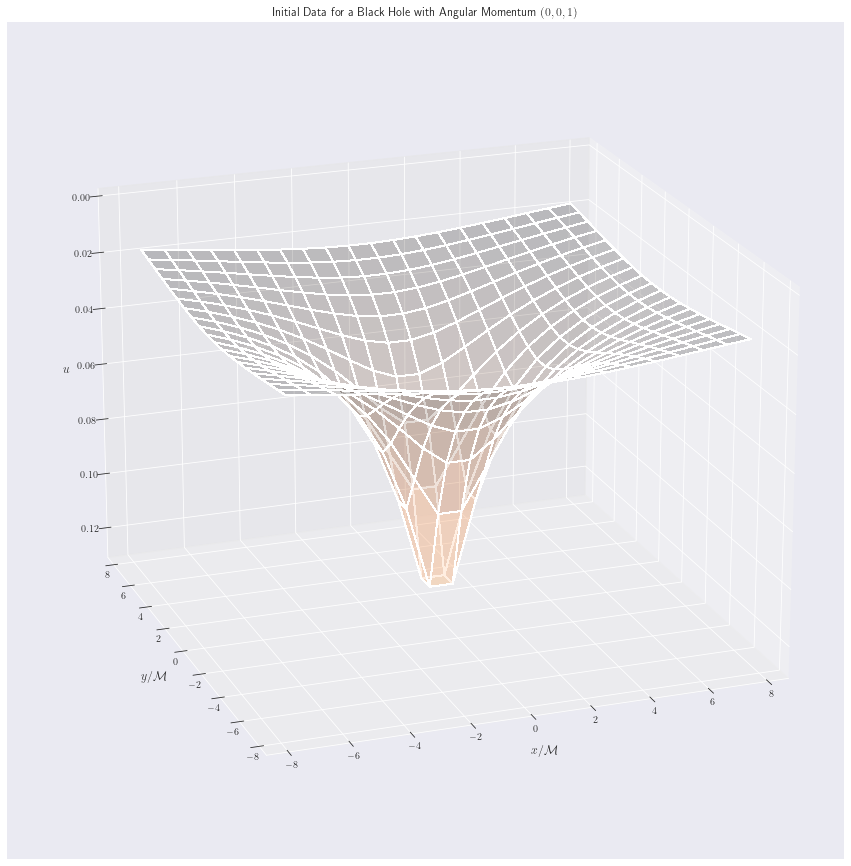

In [6]:
import sys
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import cm
import numpy as np
import matplotlib
import seaborn as sns
sns.set_style('darkgrid')
from distutils.spawn import find_executable
    
def puncture_plot(data_file, plot_file = 0):
    if find_executable('latex'):
        rc('text', usetex=True)
    #
    f = open(data_file, 'r')
    if f:
        print("Reading data from file", data_file)
    else:
        print("Cannot open data file", data_file)
        return
    x, y, fct = np.loadtxt(data_file, unpack=True)
    f.close()
    #
    n_grid = int(np.sqrt(x.size))
    X = np.reshape(x, (n_grid, n_grid))
    Y = np.reshape(y, (n_grid, n_grid))
    FCT = np.reshape(fct, (n_grid, n_grid))
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.plot_surface(X, Y, FCT, cmap=cm.copper, linewidth=1,
                    antialiased=False, alpha=0.2)
    #ax.contour(X, Y, FCT, zdir='z', offset=0.0, cmap=cm.autumn)
    
    if find_executable('latex'):
        ax.set_xlabel(r"$x / {\mathcal M}$", size=12)
        ax.set_ylabel(r"$y / {\mathcal M}$", size=12)
        ax.set_zlabel(r"$u$", size=12)
    else:
        ax.set_xlabel("x / M", size=14)
        ax.set_ylabel("y / M", size=14)
        ax.set_zlabel("u", size=14)        
    ax.set_zlim(0.0, max(fct)+0.01)
    ax.tick_params(axis='x', which='major', pad = -2)
    ax.tick_params(axis='y', which='major', pad = -2)
    ax.xaxis.set_rotate_label(False)
    ax.yaxis.set_rotate_label(False)
    ax.zaxis.set_rotate_label(False)
    ax.invert_zaxis()
    ax.view_init(elev=20., azim=-110)
    plt.rcParams['figure.figsize'] = [15, 20]
    plt.title("Initial Data for a Black Hole with Angular Momentum $(0,0,1)$")

 
    if plot_file == 0:
        plt.show()
    else:
        plt.savefig(plot_file, psi=300)


def main():
    """Main routine..."""
    print(" ------------------------------------------------------------")
    print(" --- puncture_plot.py --- use flag -h for list of options ---")
    print(" ------------------------------------------------------------")
    # print("Using matplotlib version", matplotlib.__version__)
    #
    # set default values for variables
    #
    # data filename
    data_file = "Puncture_spin20_8.0.data"
    # filename to be plotted to (set to zero for display on screen)
    plot_file = 0
    #
    # now look for flags to overwrite default values
    #
    for i in range(len(sys.argv)):
        if sys.argv[i] == "-h":
            usage()
            return
        if sys.argv[i] == "-data":
            data_file = sys.argv[i+1]
        if sys.argv[i] == "-plot":
            plot_file = sys.argv[i+1]
    #
    # plot puncture data...
    #
    puncture_plot(data_file, plot_file)

def usage():
    print("Creates plots from data files produced with puncture.py.")
    print("")
    print("The following options can be used to over-write default parameters")
    print("\t-data: provide name of data_file [Default: Puncture_16_4.0.data] ")
    print("\t-plot: if provided, plot will be saved to this file [Default: None]")
    print("")
    print("For example, to make a plot of the file Puncture_24_6.0.data")
    print("and save to file plot.pdf, call")
    print("\tpython3 puncture_plot.py -data Puncture_24_6.0.data -plot plot.pdf")


if __name__ == '__main__':
    main()

    
# puncture()
# compare_formulations()
# convergence()
# outbound_convergence()
